In [10]:
import numpy as np
import pandas as pd

import cvxopt
import yfinance as yf
import pandas_datareader

from datetime import datetime
from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn') # style.use('ggplot') # style.use('fivethirtyeight')
%matplotlib inline

# pandas precision
pd.options.display.precision = 4

# Markowitz's Min-Variance Model

In [11]:
df_topix30 = pd.read_csv("../../data/tmp/tse_topixcore30_20131031.csv")
df_topix30.head()

日付   コード              銘柄名     市場・商品区分  33業種コード 33業種区分  17業種コード  \
0  20201030  2914          日本たばこ産業  市場第一部（内国株）     3050    食料品        1   
1  20201030  3382  セブン＆アイ・ホールディングス  市場第一部（内国株）     6100    小売業       14   
2  20201030  4063           信越化学工業  市場第一部（内国株）     3200     化学        4   
3  20201030  4452               花王  市場第一部（内国株）     3200     化学        4   
4  20201030  4502           武田薬品工業  市場第一部（内国株）     3250    医薬品        5   

  17業種区分 規模コード           規模区分  
0     食品     2  TOPIX Large70  
1     小売     1   TOPIX Core30  
2  素材・化学     1   TOPIX Core30  
3  素材・化学     1   TOPIX Core30  
4    医薬品     1   TOPIX Core30

In [12]:
stocks_topix30 = df_topix30['コード'].values
stocks_topix30

array([2914, 3382, 4063, 4452, 4502, 4503, 5401, 6301, 6501, 6502, 6752,
       6758, 6954, 7201, 7203, 7267, 7751, 8031, 8058, 8306, 8316, 8411,
       8604, 8766, 8802, 9021, 9432, 9433, 9437, 9984])

In [13]:
st = '2013/10/31' # st = datetime(2013, 10, 31)
ed = '2018/10/31' # ed = datetime(2018, 10, 31)

symbols =  [str(s)+'.T' for s in stocks_topix30]

dfs = []
for symbol in symbols:
    df = pandas_datareader.data.DataReader(symbol, 'yahoo', st, ed) # daily
    df = df.resample('M').mean() # daily -> monthly
    df = df.sort_values(by='Date', ascending=True)
    df = df.fillna(method='ffill') # 1つ前の行の値で埋める
    df = df[['Close']].rename(columns={'Close': symbol})
    dfs.append(df)

df = pd.concat(dfs, axis=1)

In [14]:
display(df.head(5))
display(df.tail(5))

2914.T     3382.T     4063.T     4452.T     4502.T     4503.T  \
Date                                                                           
2013-10-31  3550.0000  3620.0000  5530.0000  3265.0000  4665.0000  1092.0000   
2013-11-30  3563.2500  3676.0000  5811.0000  3321.2500  4799.2500  1186.8000   
2013-12-31  3444.7500  3880.2500  5927.0000  3287.0000  5037.7500  1204.8000   
2014-01-31  3204.1053  4245.5789  5829.2105  3304.7368  4816.0000  1241.7895   
2014-02-28  3267.8947  3912.7895  5658.3158  3298.8947  4771.5789  1254.5579   

               5401.T     6301.T     6501.T     6502.T  ...     8316.T  \
Date                                                    ...              
2013-10-31  3230.0000  2140.0000  3425.0000  4160.0000  ...  4715.0000   
2013-11-30  3278.0000  2140.1000  3524.7500  4193.0000  ...  4964.7500   
2013-12-31  3354.5000  2077.7000  3803.2500  4311.0000  ...  5136.7500   
2014-01-31  3321.5789  2082.6316  4157.6316  4735.2632  ...  5230.2105   
2014-02-28  3017.3684  2091.4737  3969.2105  4299.4737  ...  4708.6842   

               8411.T    8604.T     8766.T     8802.T     9021.T     9432.T  \
Date                                                                          
2013-10-31  2050.0000  723.0000  3205.0000  2797.0000  4395.0000  1272.5000   
2013-11-30  2127.0000  770.2500  3314.0000  2820.4000  4439.5000  1295.0000   
2013-12-31  2140.0000  785.1000  3389.7500  2881.5000  4446.2500  1341.1250   
2014-01-31  2295.7895  785.1579  3269.3684  2859.0000  4423.5789  1410.9605   
2014-02-28  2122.6316  695.1053  3044.1053  2494.0526  4173.2105  1391.7895   

               9433.T     9437.T     9984.T  
Date                                         
2013-10-31  1770.0000  1560.0000  3650.0000  
2013-11-30  1999.5000  1592.1500  3923.2500  
2013-12-31  2109.1670  1664.7500  4418.7500  
2014-01-31  2064.0005  1705.6316  4277.6053  
2014-02-28  1912.4031  1640.4211  3798.2105  

[5 rows x 30 columns]

2914.T     3382.T      4063.T     4452.T     4502.T     4503.T  \
Date                                                                            
2018-06-30  3075.6667  4882.5238  10511.6667  8450.7143  4377.4762  1731.7143   
2018-07-31  3023.7500  4582.8182  10456.7273  8204.3182  4658.2273  1776.1591   
2018-08-31  3047.3478  4544.6522  10762.3913  8234.3478  4651.4783  1869.8696   
2018-09-30  2935.3250  4851.2000   9800.7500  8830.6000  4661.8000  1912.0750   
2018-10-31  2923.5870  4917.1739   9283.9130  8286.4783  4547.5652  1865.6304   

               5401.T     6301.T     6501.T     6502.T  ...     8316.T  \
Date                                                    ...              
2018-06-30  2242.2143  3326.8571  4002.6667  3247.1429  ...  4458.8571   
2018-07-31  2146.2273  3218.4545  3924.2273  3445.9091  ...  4344.1818   
2018-08-31  2257.6304  3128.9130  3705.3913  3308.6957  ...  4385.2609   
2018-09-30  2249.3250  3215.5500  3686.1500  3251.5000  ...  4459.3500   
2018-10-31  2233.3261  3140.5217  3524.8261  3290.6522  ...  4472.6957   

               8411.T    8604.T     8766.T     8802.T     9021.T     9432.T  \
Date                                                                          
2018-06-30  1904.2857  558.9000  5410.4286  1976.1429  8058.5714  2584.8810   
2018-07-31  1906.5000  540.6000  5275.5909  1915.8864  7857.7273  2536.5000   
2018-08-31  1951.8696  512.4609  5292.2609  1818.0652  7569.7826  2569.1304   
2018-09-30  1964.8000  528.3650  5335.5500  1858.6750  7637.6000  2507.4250   
2018-10-31  1940.0870  545.6478  5427.8696  1835.5652  7600.3478  2477.4348   

               9433.T     9437.T     9984.T  
Date                                         
2018-06-30  3016.5000  2832.8810  4072.9524  
2018-07-31  3103.3182  2843.6818  4556.9773  
2018-08-31  3044.1957  2912.1087  4996.9783  
2018-09-30  3035.6000  2962.3250  5318.4000  
2018-10-31  2944.3043  2918.3913  4923.6304  

[5 rows x 30 columns]

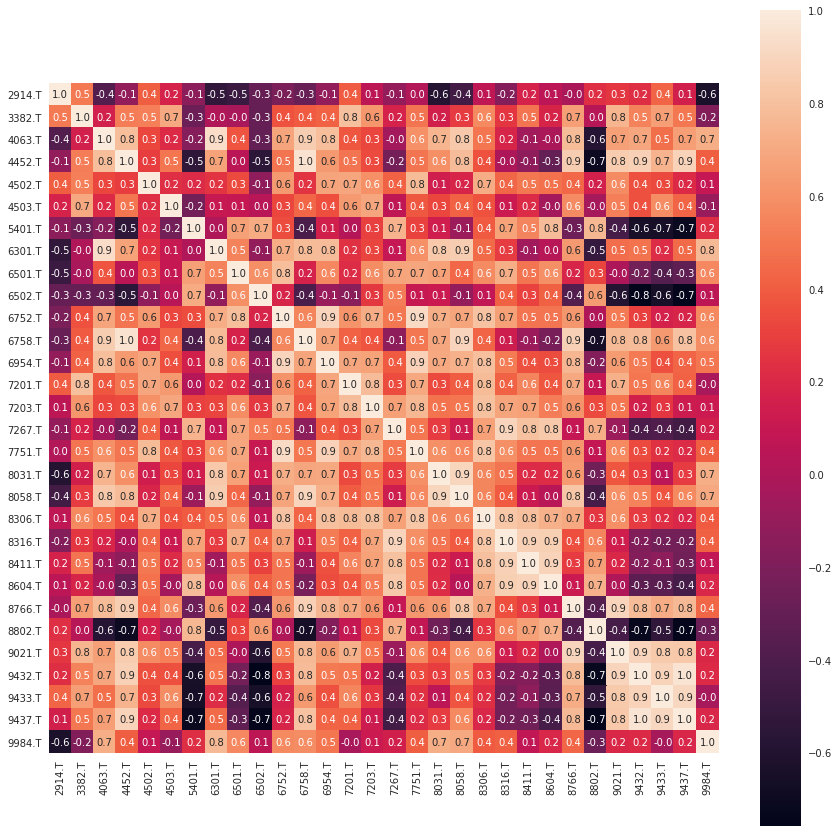

In [6]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, center=0, square=True, fmt='.1f')
plt.show()

In [7]:
def calc_returns(df):
    """
    calculate change ratio of returns && cumulative returns
    """
    # df = df.fillna(method='ffill')

    # 収益率(returns change)
    df_retchg = df.pct_change()
    df_retchg[:1] = 0.0 # 最初の行を0.0に直す
    
    # 累積収益率 (cumulative returns)
    df_retcum = (1 + df_retchg).cumprod()
    df_retcum[:1] = 1.0 # 最初の行を1.0に直す
    
    return df_retcum, df_retchg

In [8]:
df_retcum, df_retchg = calc_returns(df)

display(df_retchg.head(3))
display(df_retchg.tail(3))

display(df_retcum.head(3))
display(df_retcum.tail(3))

2914.T    3382.T    4063.T    4452.T    4502.T    4503.T  \
Date                                                                     
2013-10-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2013-11-30  0.003732  0.015470  0.050814  0.017228  0.028778  0.086813   
2013-12-31 -0.033256  0.055563  0.019962 -0.010312  0.049695  0.015167   

              5401.T    6301.T    6501.T    6502.T  ...    8316.T    8411.T  \
Date                                                ...                       
2013-10-31  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2013-11-30  0.014861  0.000047  0.029124  0.007933  ...  0.052969  0.037561   
2013-12-31  0.023337 -0.029158  0.079013  0.028142  ...  0.034644  0.006112   

              8604.T    8766.T    8802.T    9021.T    9432.T    9433.T  \
Date                                                                     
2013-10-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2013-11-30  0.065353  0.034009  0.008366  0.010125  0.017682  0.129661   
2013-12-31  0.019279  0.022858  0.021664  0.001520  0.035618  0.054847   

              9437.T    9984.T  
Date                            
2013-10-31  0.000000  0.000000  
2013-11-30  0.020609  0.074863  
2013-12-31  0.045599  0.126298  

[3 rows x 30 columns]

2914.T    3382.T    4063.T    4452.T    4502.T    4503.T  \
Date                                                                     
2018-08-31  0.007804 -0.008328  0.029231  0.003660 -0.001449  0.052760   
2018-09-30 -0.036761  0.067452 -0.089352  0.072410  0.002219  0.022571   
2018-10-31 -0.003999  0.013600 -0.052734 -0.061618 -0.024504 -0.024290   

              5401.T    6301.T    6501.T    6502.T  ...    8316.T    8411.T  \
Date                                                ...                       
2018-08-31  0.051907 -0.027821 -0.055765 -0.039819  ...  0.009456  0.023797   
2018-09-30 -0.003679  0.027689 -0.005193 -0.017286  ...  0.016895  0.006625   
2018-10-31 -0.007113 -0.023333 -0.043765  0.012041  ...  0.002993 -0.012578   

              8604.T    8766.T    8802.T    9021.T    9432.T    9433.T  \
Date                                                                     
2018-08-31 -0.052052  0.003160 -0.051058 -0.036645  0.012864 -0.019051   
2018-09-30  0.031035  0.008180  0.022337  0.008959 -0.024018 -0.002824   
2018-10-31  0.032710  0.017303 -0.012433 -0.004877 -0.011961 -0.030075   

              9437.T    9984.T  
Date                            
2018-08-31  0.024063  0.096555  
2018-09-30  0.017244  0.064323  
2018-10-31 -0.014831 -0.074227  

[3 rows x 30 columns]

2914.T    3382.T    4063.T    4452.T    4502.T    4503.T  \
Date                                                                     
2013-10-31  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2013-11-30  1.003732  1.015470  1.050814  1.017228  1.028778  1.086813   
2013-12-31  0.970352  1.071892  1.071790  1.006738  1.079904  1.103297   

              5401.T    6301.T    6501.T    6502.T  ...    8316.T    8411.T  \
Date                                                ...                       
2013-10-31  1.000000  1.000000  1.000000  1.000000  ...  1.000000  1.000000   
2013-11-30  1.014861  1.000047  1.029124  1.007933  ...  1.052969  1.037561   
2013-12-31  1.038545  0.970888  1.110438  1.036298  ...  1.089449  1.043902   

              8604.T    8766.T    8802.T    9021.T    9432.T    9433.T  \
Date                                                                     
2013-10-31  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2013-11-30  1.065353  1.034009  1.008366  1.010125  1.017682  1.129661   
2013-12-31  1.085892  1.057644  1.030211  1.011661  1.053929  1.191620   

              9437.T    9984.T  
Date                            
2013-10-31  1.000000  1.000000  
2013-11-30  1.020609  1.074863  
2013-12-31  1.067147  1.210616  

[3 rows x 30 columns]

2914.T    3382.T    4063.T    4452.T    4502.T    4503.T  \
Date                                                                     
2018-08-31  0.858408  1.255429  1.946183  2.522005  0.997101  1.712335   
2018-09-30  0.826852  1.340110  1.772288  2.704625  0.999314  1.750984   
2018-10-31  0.823546  1.358335  1.678827  2.537972  0.974826  1.708453   

              5401.T    6301.T    6501.T    6502.T  ...    8316.T    8411.T  \
Date                                                ...                       
2018-08-31  0.698957  1.462109  1.081866  0.795360  ...  0.930066  0.952131   
2018-09-30  0.696385  1.502593  1.076248  0.781611  ...  0.945779  0.958439   
2018-10-31  0.691432  1.467534  1.029146  0.791022  ...  0.948610  0.946384   

              8604.T    8766.T    8802.T    9021.T    9432.T    9433.T  \
Date                                                                     
2018-08-31  0.708798  1.651251  0.650005  1.722362  2.018963  1.719885   
2018-09-30  0.730795  1.664758  0.664524  1.737793  1.970472  1.715028   
2018-10-31  0.754700  1.693563  0.656262  1.729317  1.946904  1.663449   

              9437.T    9984.T  
Date                            
2018-08-31  1.866736  1.369035  
2018-09-30  1.898926  1.457096  
2018-10-31  1.870764  1.348940  

[3 rows x 30 columns]

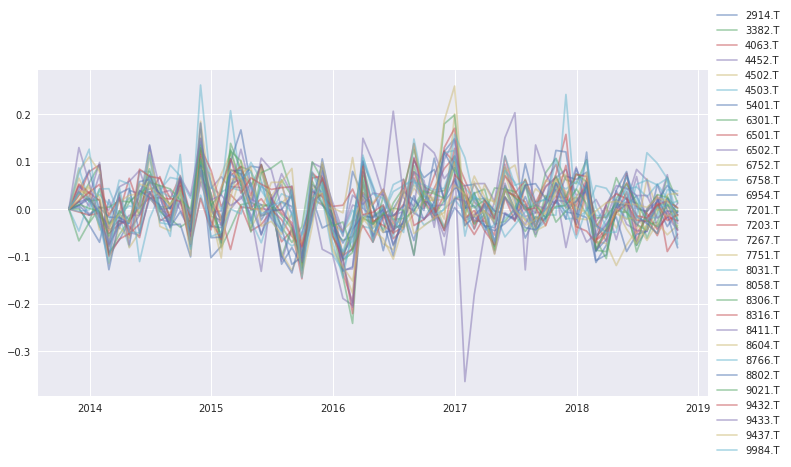

In [9]:
plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.plot(df_retchg.index, df_retchg[col], label=col.replace(".T", ""), alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

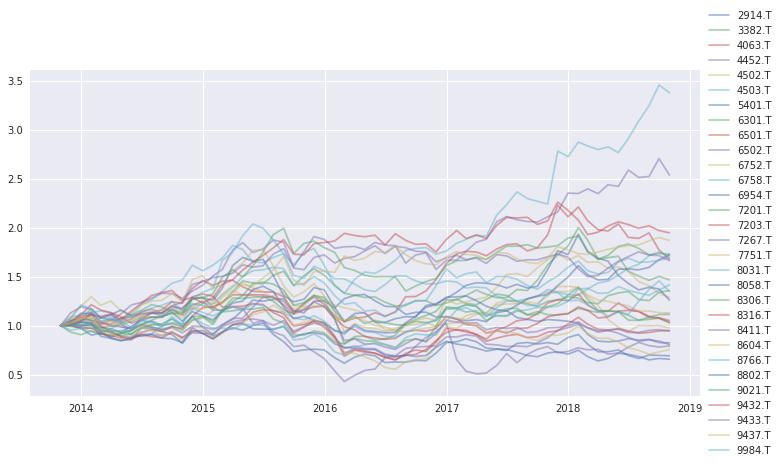

In [10]:
plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.plot(df_retcum.index, df_retcum[col], label=col.replace(".T", ""), alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

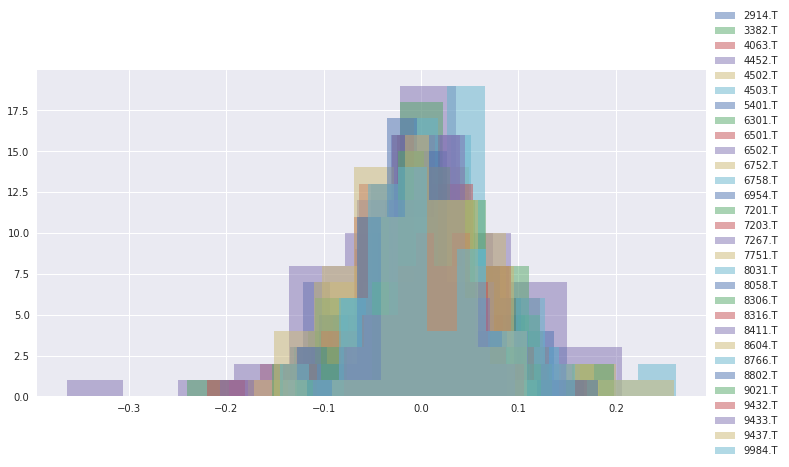

In [11]:
plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.hist(df_retchg[[col]], label=col, alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

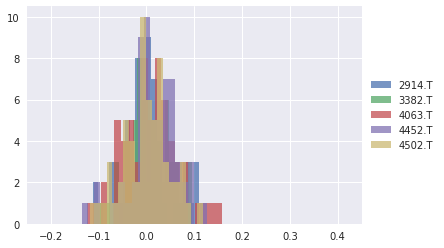

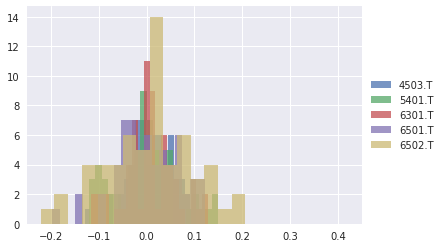

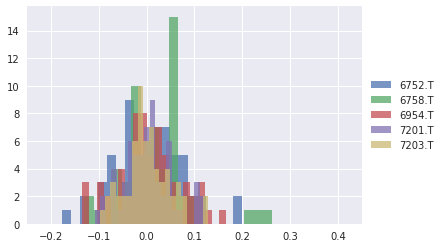

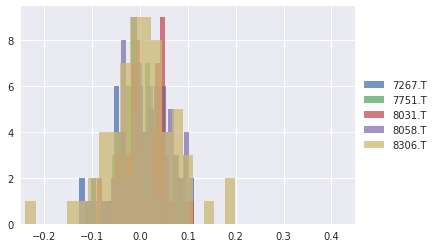

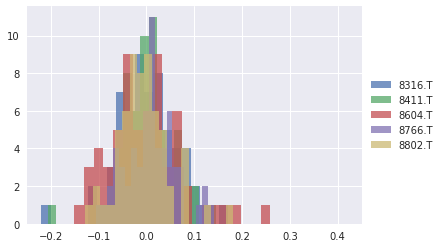

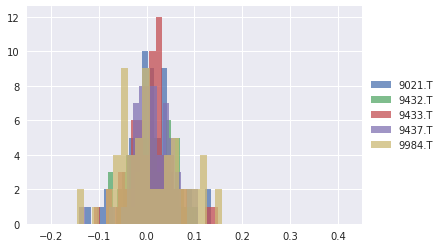

In [12]:
for idx, col in enumerate(df.columns):
    plt.hist(df_retchg[[col]].values, bins=20, label=col, alpha=0.75)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlim([-0.25, 0.45])
    if (idx + 1) % 5 == 0:
        plt.show()

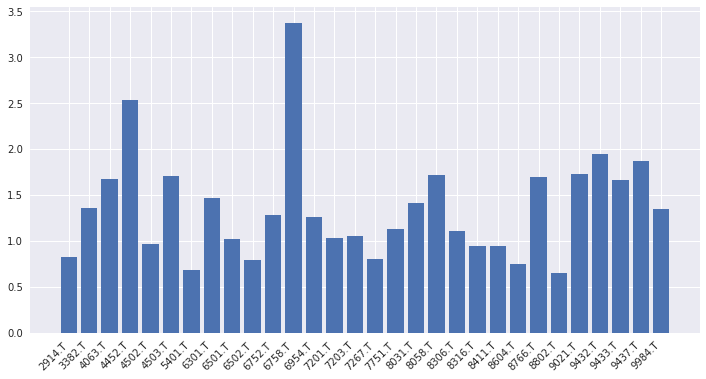

In [13]:
# cumulative returns
plt.figure(figsize=(12,6))
plt.bar(df_retchg.columns, df_retcum.iloc[-1].values)
plt.xticks(rotation=45, ha='right')
plt.show()

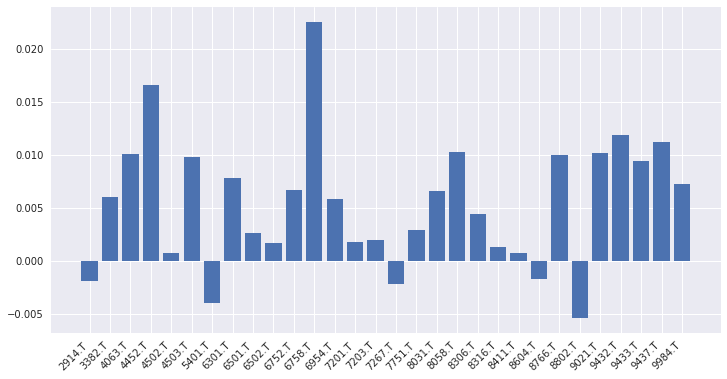

In [14]:
# expected returns
plt.figure(figsize=(12,6))
plt.bar(df_retcum.columns, df_retchg.mean().values)
plt.xticks(rotation=45, ha='right')
plt.show()

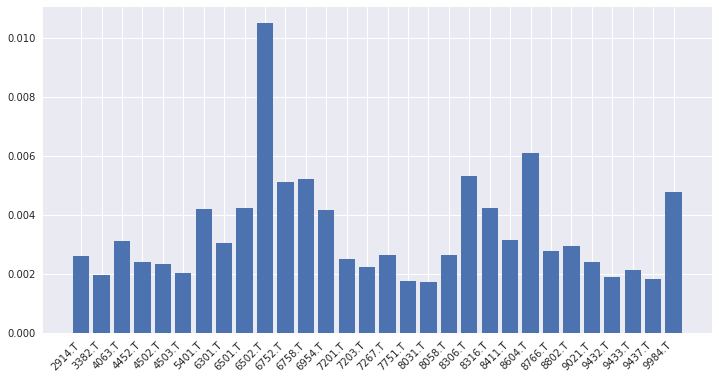

In [15]:
# variance
plt.figure(figsize=(12,6))
plt.bar(df_retcum.columns, df_retchg.var().values)
plt.xticks(rotation=45, ha='right')
plt.show()

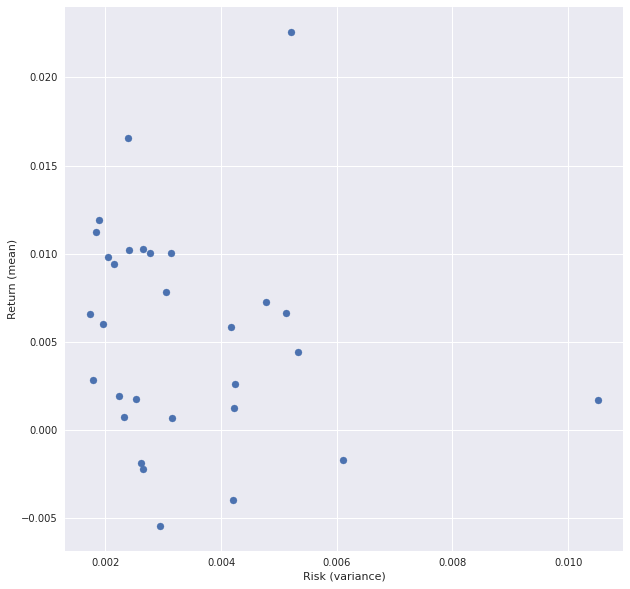

In [16]:
# returns vs risk (change)
plt.figure(figsize=(10,10))
mean = df_retchg.mean().values
var = df_retchg.var().values
plt.scatter(var, mean)
plt.xlabel("Risk (variance)")
plt.ylabel("Return (mean)")
plt.show()

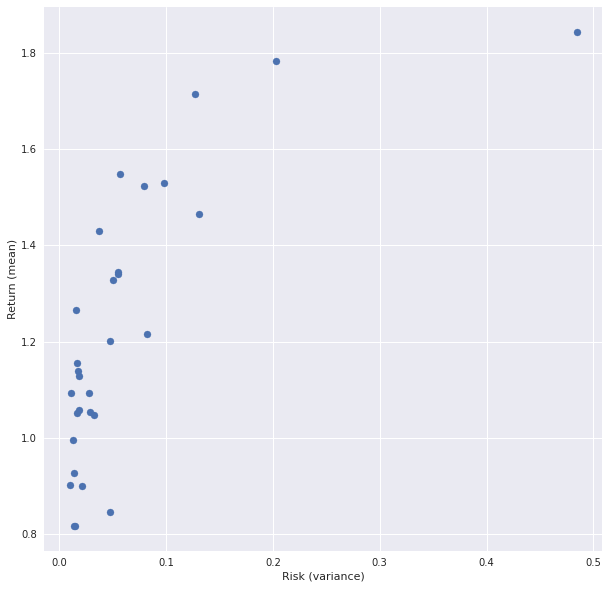

In [17]:
# returns vs risk (cumulative)
plt.figure(figsize=(10,10))
mean = df_retcum.mean().values
var = df_retcum.var().values
plt.scatter(var, mean)
plt.xlabel("Risk (variance)")
plt.ylabel("Return (mean)")
plt.show()

### ポートフォリオ選択モデル

**Markowitzの平均分散モデル**

Markowitzの平均分散モデルでは，「ポートフォリオの期待収益率(Expected return)が一定値以上となる」という制約条件の下で，「ポートフォリオの分散を最小化する」最適化問題を考える．一般に，$n$コの資産で構成されるポートフォリオの場合，ポートフォリオの分散は$n$コの資産間の共分散行列の二次形式となるので，この最適化問題は二次計画問題(Quadratic Programming, QP)のクラスとなり，次のように定式化される．

\begin{align}
    \underset{\bf x \in \mathcal{X}}{\rm minimize} ~~~ 
    &\sigma_p \left( = {\bf x}^{\mathrm{T}} \Sigma {\bf x} \right) \\
    {\rm subject~to} ~~~ &\bar{r}_p = \bar{\bf r}^{\mathrm{T}} {\bf x} = \sum_{i=1}^{n} \bar{r}_i x_i \geq r_e \\
    &{\| {\bf x} \|}_{1} = \sum_{i=1}^{n} x_i = 1 \\
    &x_i \geq 0 ~~ (i = 1, \cdots, n)
\end{align}

- $\Sigma \in \mathbb{R}^{n \times n}$ - $n$コの資産の共分散行列
- ${\bf x} \in \mathbb{R}^{n}$ - $n$コの資産の投資比率ベクトル
- $\bar{\bf r} \in \mathbb{R}^{n}$ - $n$コの資産の期待収益率ベクトル
- $x_i \in \mathbb{R}$ - 資産$i$の投資比率
- $\bar{r}_i \in \mathbb{R}$ - 資産$i$の期待収益率
- $r_e \in \mathbb{R}$ - 投資家の要求期待収益率
- $\bar{r}_p \in \mathbb{R}$ - ポートフォリオの期待収益率
- $\sigma_p \in \mathbb{R}$ - ポートフォリオの標準偏差

1つ目の制約式は，ポートフォリオの期待収益率が一定値($=r_e$)以上となることを要請している．2つ目，3つ目の制約式はポートフォリオの定義からくる自明なものである．資産の空売りを許す場合，3つ目の制約式を除くこともある．

**二次計画問題**

Pythonの凸最適化向けパッケージ[CVXOPT](https://cvxopt.org)を使って，二次計画問題(QP)を解く．
CVXOPTで二次計画問題を扱う場合は，解きたい最適化問題を以下の一般化されたフォーマットに整理して，

\begin{align}
\underset{\bf x}{\rm minimize} ~~~ &\frac{1}{2} {\bf x}^{T} P {\bf x} + {\bf q}^{T} {\bf x} \\\
{\rm subject~to} ~~~ & G {\bf x} \leq {\bf h} \\\
&A {\bf x} = {\bf b}
\end{align}

パラメータ$P,q,G,h,A$を計算し，[cvxopt.solvers.qp()](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)関数を実行することで最適解と最適値を求める．Markowitzの平均・分散モデルの場合は次のようになる．

\begin{align}
    P = 2 \cdot \Sigma, \hspace{1em}
    q = {\bf 0}_n, \hspace{1em}
    G = -1 \cdot
        \begin{pmatrix}
            \bar{r}_1 & \cdots & \bar{r}_n \\
            1 & \cdots & 0 \\
            \vdots & \ddots & \vdots \\
            0 & \cdots & 1 
        \end{pmatrix}, \hspace{1em}
    h = -1 \cdot 
        \left(
            \begin{array}{c}
              r_e \\
              0 \\
              \vdots \\
              0
            \end{array}
        \right), \hspace{1em}
    A = {\bf 1}_n^{T}, \hspace{1em}
    b = 1
\end{align}



参考:
- https://cvxopt.org/userguide/coneprog.html
- https://qiita.com/ryoshi81/items/8b0c6add3e367f94c828

In [18]:
import cvxopt

def cvxopt_qp_solver(r, r_e, cov):
    # CVXOPT QP Solver for Markowitz' Mean-Variance Model
    # See https://cvxopt.org/userguide/coneprog.html#quadratic-programming
    # See https://cdn.hackaday.io/files/277521187341568/art-mpt.pdf
    n = len(r)
    r = cvxopt.matrix(r)
    
    # Create Objective matrices
    P = cvxopt.matrix(2.0 * np.array(cov))
    q = cvxopt.matrix(np.zeros((n, 1)))
    
    # Create constraint matrices
    G = cvxopt.matrix(np.concatenate((-np.transpose(r), -np.eye(n)), 0))
    h = cvxopt.matrix(np.concatenate((-np.ones((1,1)) * r_e, np.zeros((n,1))), 0))
    A = cvxopt.matrix(1.0, (1, n))
    b = cvxopt.matrix(1.0)
    
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    return sol

In [19]:
r = df_retchg.mean().values
r_e = 0.001
cov = np.array(df_retcum.cov())

sol = cvxopt_qp_solver(r, r_e, cov)
x_opt = np.squeeze(np.array(sol['x']))
print(x_opt)
print("min var (opt) :", sol["primal objective"])
print("r_e           :", r_e)

     pcost       dcost       gap    pres   dres
 0:  7.6764e-03 -1.0090e+00  3e+01  6e+00  6e+00
 1:  1.4400e-02 -9.4430e-01  1e+00  4e-02  4e-02
 2:  1.3909e-02 -3.0251e-02  4e-02  6e-04  6e-04
 3:  5.9953e-03 -5.1864e-03  1e-02  2e-16  6e-17
 4:  3.9099e-03  2.8844e-04  4e-03  2e-16  2e-17
 5:  2.7358e-03  1.8139e-03  9e-04  4e-17  1e-17
 6:  2.3076e-03  2.1546e-03  2e-04  7e-17  1e-17
 7:  2.2147e-03  2.2089e-03  6e-06  2e-16  1e-17
 8:  2.2102e-03  2.2102e-03  7e-08  9e-17  1e-17
Optimal solution found.
[2.43718602e-01 4.15989035e-07 5.27284775e-07 3.39700213e-07
 6.97920854e-07 2.45888424e-07 4.99540843e-05 5.69729240e-06
 8.70166207e-07 9.17798180e-02 1.92718019e-07 1.34902574e-07
 2.59289906e-07 7.55046825e-07 4.01380607e-07 1.33910452e-05
 5.23045988e-07 1.11856486e-01 4.08237409e-07 1.83092956e-07
 5.17118504e-07 4.72518088e-07 3.65375950e-07 1.80715707e-07
 2.88627976e-01 1.62174751e-07 7.57180754e-07 6.23608872e-07
 1.19929556e-01 1.44009486e-01]
min var (opt) : 0.0022102403

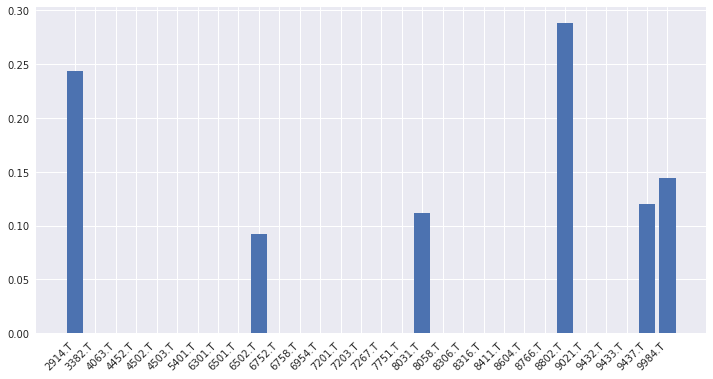

In [20]:
# Opt portfolio
plt.figure(figsize=(12,6))
plt.bar(df.columns, x_opt)
plt.xticks(rotation=45, ha='right')
plt.show()

In [21]:
meanchg = df_retchg.mean().values
meanchg_opt = float(np.dot(meanchg, x_opt))

meancum = df_retcum.iloc[-1].values
meancum_opt = float(np.dot(meancum, x_opt))

varchg = df_retchg.var().values
varchg_opt = float(np.dot(varchg, x_opt ** 2))

varcum = df_retcum.var().values
varcum_opt = float(np.dot(varcum, x_opt ** 2))

print("opt portfolio\n=============")
print("mean chg :", meanchg_opt)
print("var chg  :", varchg_opt)
print("mean cum :", meancum_opt)
print("var cum  :", varcum_opt)

opt portfolio
mean chg : 0.0012432906721252593
var chg  : 0.0006355531771119059
mean cum : 1.0397300313673306
var cum  : 0.004621569782430522


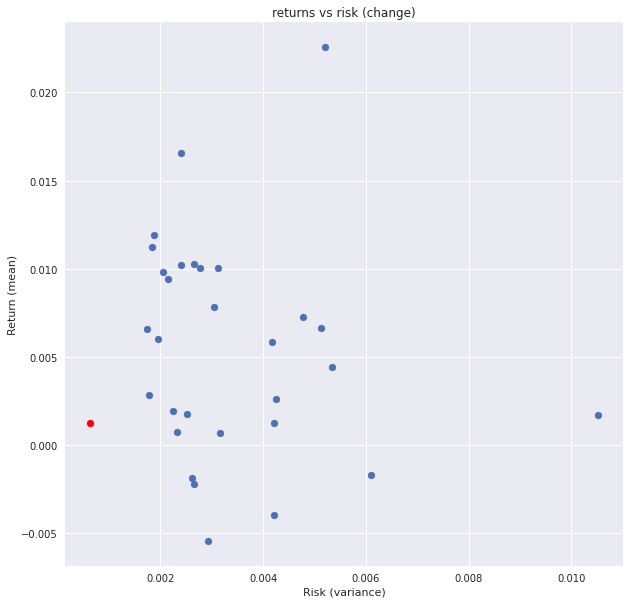

In [22]:
# returns vs risk (change)
plt.figure(figsize=(10,10))
plt.scatter(varchg, meanchg)
plt.scatter(varchg_opt, meanchg_opt, marker="o", color="red")
plt.title("returns vs risk (change)")
plt.xlabel("Risk (variance)")
plt.ylabel("Return (mean)")
plt.show()

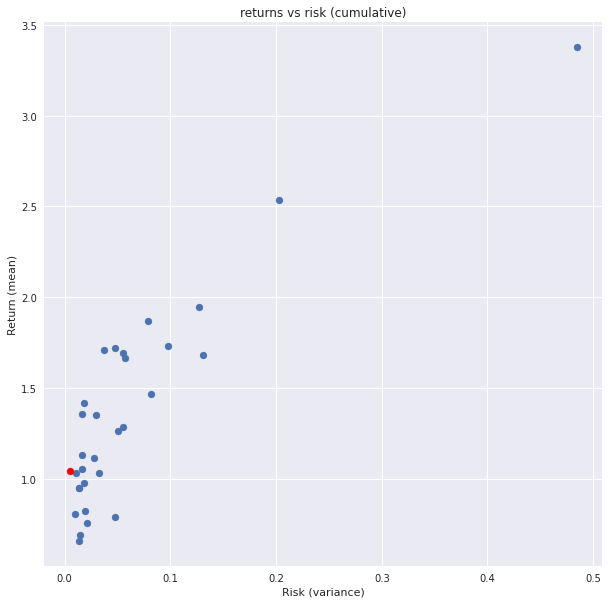

In [23]:
# returns vs risk (cumulative)
plt.figure(figsize=(10,10))
plt.scatter(varcum, meancum)
plt.scatter(varcum_opt, meancum_opt, marker="o", color="red")
plt.title("returns vs risk (cumulative)")
plt.xlabel("Risk (variance)")
plt.ylabel("Return (mean)")
plt.show()

# Backtest

to evaluate the Sharpe-ratio performance of the given portfolio

In [34]:
class MarkowitzMinVarianceModel():
    """
    Args:
    =====
    - df: pandas.dataframe
        panel data for target assets for the portfolio. 
            its index must be `numpy.datetime64` type.
            its columns must be time-series data of target assets.
    - window_size: int
        the size of time-window which is used when deriving (or updating) the portfolio.
    - rebalance_freq: int
        rebalance frequency of the portfolio.
    - r_e: float
        min of the return ratio (= capital gain / investment).
    - r_f: float
        rate of returns of the risk-free asset.
    """
    def __init__(self, df, window_size, rebalance_freq, r_e=None, r_f=None):
        
        self.df = df
        self.df_chg = df.pct_change()
        self.df_chg[:1] = 0.0 # set 0.0 to the first record
        self.df_bt = None
        self.window_size = window_size
        self.rebalance_freq = rebalance_freq
        self.jgb_int = 0.0001 # 0.01% per year (Japanese Government Bond)
        self.r_f = r_f if r_f is not None else self.jgb_int * (1/12) # adjust monthly
        self.r_e = r_e if r_e is not None else r_f
        
    def backtest(self):
        date_init = self.df.index.values[self.window_size]
        df_bt = pd.DataFrame([[0.0, np.nan]], index=[date_init], columns=['ror', 'std'])
        for idx, date in enumerate(self.df.index.values):
            if idx >= self.window_size + self.rebalance_freq:
                if (idx - self.window_size) % self.rebalance_freq == 0:
                    # df_chg_train
                    st = idx - self.rebalance_freq - self.window_size
                    ed = idx - self.rebalance_freq
                    df_chg_train = self.df_chg[st:ed]
                    
                    # x_p: min variance portfolio
                    x_p = self.calc_portfolio(df_chg_train, self.r_e)
                    
                    # df_chg_test
                    st = idx - self.rebalance_freq
                    ed = idx
                    df_chg_test = self.df_chg[st:ed]
                    df_chgcum_test = (1.0 + df_chg_test).cumprod() - 1.0
                                                            
                    # ror_p: rate of return (portfolio)
                    ror_test = df_chgcum_test.iloc[-1].values
                    ror_p = float(np.dot(ror_test, x_p))
                    
                    # std (portfolio)
                    if self.rebalance_freq == 1:
                        std_p = np.nan
                    else:
                        std_test = df_chg_test.std(ddof=True).values
                        std_p = float(np.dot(std_test, np.abs(x_p)))

                    # append
                    df_one = pd.DataFrame([[ror_p, std_p]], index=[date], columns=df_bt.columns)                    
                    df_bt = df_bt.append(df_one)
        self.df_bt = df_bt
        return df_bt

    def calc_portfolio(self, df_retchg, r_e):
        r = df_retchg.mean().values
        cov = np.array(df_retchg.cov())
        x_opt = self.cvxopt_qp_solver(r, r_e, cov)
        return x_opt
        
    def cvxopt_qp_solver(self, r, r_e, cov):
        """
        CVXOPT QP Solver for Markowitz' Mean-Variance Model
        - See also https://cvxopt.org/userguide/coneprog.html#quadratic-programming
        - See also https://cdn.hackaday.io/files/277521187341568/art-mpt.pdf
        
        r: mean returns of target assets. (vector)
        r_e: min of the return ratio (= capital gain / investment).
        cov: covariance matrix of target assets. (matrix)
        """
        n = len(r)
        r = cvxopt.matrix(r)

        # Create Objective matrices
        P = cvxopt.matrix(2.0 * np.array(cov))
        q = cvxopt.matrix(np.zeros((n, 1)))

        # Create constraint matrices
        G = cvxopt.matrix(np.concatenate((-np.transpose(r), -np.eye(n)), 0))
        h = cvxopt.matrix(np.concatenate((-np.ones((1,1))*r_e, np.zeros((n,1))), 0))
        A = cvxopt.matrix(1.0, (1, n))
        b = cvxopt.matrix(1.0)
        
        # stop log messages
        cvxopt.solvers.options['show_progress'] = False
        
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        x_opt = np.squeeze(np.array(sol['x']))
        return x_opt
    
    def calc_returns(self, df):
        # Rate of returns
        df_retchg = df.pct_change()
        df_retchg[:1] = 0.0 # set 0.0 to the first record
        
        # Cumulative returns)
        df_retcum = (1.0 + df_retchg).cumprod() - 1.0
        df_retcum[:1] = 0.0 # set 0.0 to the first record
        
        return df_retcum, df_retchg
    
    def evaluate_backtest(self, logging=False):   
        if self.df_bt is None:
            pass
        else:
            self.r_mean = self.df_bt["ror"].mean()
            self.r_std = self.df_bt["ror"].std(ddof=True)
            self.sharpe_ratio = (self.r_mean - self.r_f) / self.r_std
            self.net_capgain = (self.df_bt["ror"] + 1.0).cumprod().iloc[-1] - 1.0
            
            self.r_mean_peryear = 12 * self.r_mean
            self.r_std_peryear = np.sqrt(12) * self.r_std
            self.sharpe_ratio_peryear = (self.r_mean_peryear - self.jgb_int) / self.r_std_peryear

            if logging:
                print("Portfolio Performance")
                print("=======================")
                print("Returns per month")
                print("  sharpe ratio     : {:.8f}".format(self.sharpe_ratio))
                print("  mean of returns  : {:.8f}".format(self.r_mean))
                print("  std of returns   : {:.8f}".format(self.r_std))
                print("    risk-free rate : {:.8f}".format(self.r_f))
                print("    capgain ratio  : {:.8f}".format(self.net_capgain))
                print("Returns per year")
                print("  sharpe ratio     : {:.8f}".format(self.sharpe_ratio_peryear))
                print("  mean of returns  : {:.8f}".format(self.r_mean_peryear))
                print("  std of returns   : {:.8f}".format(self.r_std_peryear))
                
            
    def plot_returns(self):
        if self.df_bt is None:
            pass
        else:
            plt.figure(figsize=(12,6))
            plt.plot(self.df_bt.index.values, self.df_bt["ror"].values, label="rate of returns")
            plt.plot(self.df_bt.index.values, self.df_bt["ror"].cumsum().values, label="total capital gain ratio")
            plt.legend(loc="upper left")
            plt.show()

In [25]:
df_topix30 = pd.read_csv("../../data/tmp/tse_topixcore30_20131031.csv")

stocks_topix30 = df_topix30['コード'].values
symbols =  [str(s)+'.T' for s in stocks_topix30]

st = '2013/10/31' # st = datetime(2013, 10, 30)
ed = '2018/10/31' # ed = datetime(2018, 10, 30)

dfs = []
for symbol in symbols:
    df = pandas_datareader.data.DataReader(symbol, 'yahoo', st, ed) # daily
    df = df.resample('M').mean() # daily -> monthly
    df = df.sort_values(by='Date', ascending=True)
    df = df.fillna(method='ffill') # 1つ前の行の値で埋める
    df = df[['Close']].rename(columns={'Close': symbol})
    dfs.append(df)

df = pd.concat(dfs, axis=1)
df.head()

2914.T       3382.T       4063.T       4452.T       4502.T  \
Date                                                                          
2013-10-31  3550.000000  3620.000000  5530.000000  3265.000000  4665.000000   
2013-11-30  3563.250000  3676.000000  5811.000000  3321.250000  4799.250000   
2013-12-31  3444.750000  3880.250000  5927.000000  3287.000000  5037.750000   
2014-01-31  3204.105263  4245.578947  5829.210526  3304.736842  4816.000000   
2014-02-28  3267.894737  3912.789474  5658.315789  3298.894737  4771.578947   

                 4503.T       5401.T       6301.T       6501.T       6502.T  \
Date                                                                          
2013-10-31  1092.000000  3230.000000  2140.000000  3425.000000  4160.000000   
2013-11-30  1186.800000  3278.000000  2140.100000  3524.750000  4193.000000   
2013-12-31  1204.800000  3354.500000  2077.700000  3803.250000  4311.000000   
2014-01-31  1241.789467  3321.578947  2082.631579  4157.631579  4735.263158   
2014-02-28  1254.557887  3017.368421  2091.473684  3969.210526  4299.473684   

            ...       8316.T       8411.T      8604.T       8766.T  \
Date        ...                                                      
2013-10-31  ...  4715.000000  2050.000000  723.000000  3205.000000   
2013-11-30  ...  4964.750000  2127.000000  770.250000  3314.000000   
2013-12-31  ...  5136.750000  2140.000000  785.100000  3389.750000   
2014-01-31  ...  5230.210526  2295.789474  785.157895  3269.368421   
2014-02-28  ...  4708.684211  2122.631579  695.105263  3044.105263   

                 8802.T       9021.T       9432.T       9433.T       9437.T  \
Date                                                                          
2013-10-31  2797.000000  4395.000000  1272.500000  1770.000000  1560.000000   
2013-11-30  2820.400000  4439.500000  1295.000000  1999.500000  1592.150000   
2013-12-31  2881.500000  4446.250000  1341.125000  2109.166998  1664.750000   
2014-01-31  2859.000000  4423.578947  1410.960526  2064.000508  1705.631579   
2014-02-28  2494.052632  4173.210526  1391.789474  1912.403147  1640.421053   

                 9984.T  
Date                     
2013-10-31  3650.000000  
2013-11-30  3923.250000  
2013-12-31  4418.750000  
2014-01-31  4277.605263  
2014-02-28  3798.210526  

[5 rows x 30 columns]

In [35]:
# Risk-free rate (10Year-JGB, monthly interest)
r_f = (1 + 0.0001) ** (1/12) - 1.0 
r_e = 0.01

mmvp = MarkowitzMinVarianceModel(df, 
                    window_size=12,
                    rebalance_freq=3, 
                    r_e=r_e,
                    r_f=r_f)

In [36]:
df_backtest = mmvp.backtest()
display(df_backtest)

ror       std
2014-10-31  0.000000       NaN
2015-01-31  0.005727  0.056558
2015-04-30  0.210880  0.057548
2015-07-31 -0.035906  0.033349
2015-10-31 -0.089302  0.073097
2016-01-31  0.038819  0.039327
2016-04-30 -0.063239  0.046439
2016-07-31 -0.061337  0.033097
2016-10-31 -0.017646  0.051421
2017-01-31  0.096598  0.039321
2017-04-30 -0.032708  0.034256
2017-07-31  0.086965  0.045500
2017-10-31  0.001050  0.020531
2018-01-31  0.091564  0.066284
2018-04-30 -0.024619  0.045039
2018-07-31  0.084681  0.026466
2018-10-31  0.037548  0.028225

In [37]:
interest_jgb = 0.0001 # 0.01% per year

r_mean = df_backtest["ror"].mean()
r_std = df_backtest["ror"].std() * (len(df_backtest)) / (len(df_backtest)-1)
r_f = (1 + interest_jgb) ** (1/12) - 1.0 
sharpe_ratio = (r_mean - r_f) / r_std
net_capgain = (df_backtest["ror"] + 1.0).cumprod().iloc[-1] - 1.0

print("Portfolio Performance")
print("=====================")
print("mean of returns : {:.8f}".format(r_mean))
print("std of returns  : {:.8f}".format(r_std))
print("risk-free rate  : {:.8f}".format(r_f))
print("sharpe ratio    : {:.8f}".format(sharpe_ratio))
print("capgain ratio   : {:.8f}".format(net_capgain))

Portfolio Performance
mean of returns : 0.01935736
std of returns  : 0.08079231
risk-free rate  : 0.00000833
sharpe ratio    : 0.23949096
capgain ratio   : 0.32687957


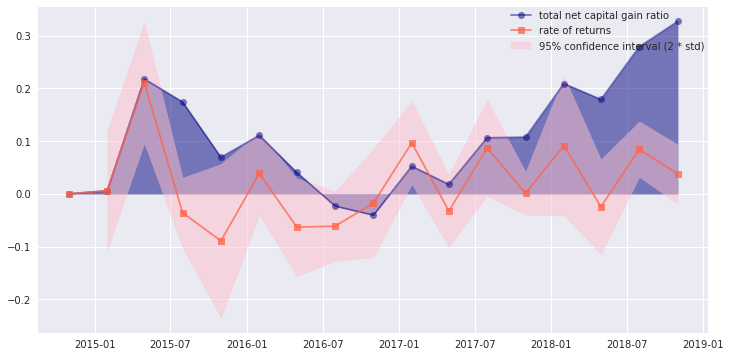

In [38]:
fig, ax = plt.subplots(figsize=(12,6))

# ror cum
x = df_backtest.index.values
y = (df_backtest["ror"] + 1.0).cumprod() - 1.0
ymin = np.zeros(len(y))
ymax = y
ax.fill_between(x, ymin, ymax, color="navy", alpha=0.5)
ax.plot(x, y, color="navy", marker="o", alpha=0.5, label="total net capital gain ratio")

# ror
y = df_backtest["ror"].values
ax.plot(x, y, color="tomato", alpha=0.75, marker="s", label="rate of returns")

# ror std
ymin = df_backtest["ror"].values - 2 * df_backtest["std"].values
ymax = df_backtest["ror"].values + 2 * df_backtest["std"].values
ax.fill_between(x, ymin, ymax, color="pink", alpha=0.5, label="95% confidence interval (2 * std)")

ax.legend(loc='upper right', borderaxespad=0.) 
plt.show()

Portfolio Performance
Returns per month
  sharpe ratio     : 0.25445915
  mean of returns  : 0.01935736
  std of returns   : 0.07603982
    risk-free rate : 0.00000833
    capgain ratio  : 0.32687957
Returns per year
  sharpe ratio     : 0.88147234
  mean of returns  : 0.23228833
  std of returns   : 0.26340966


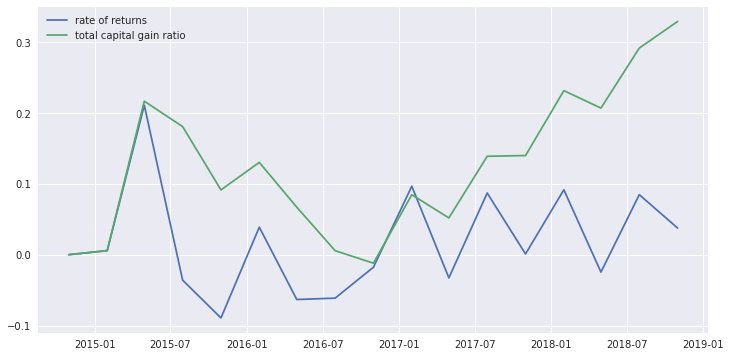

In [39]:
mmvp.evaluate_backtest(logging=True)
mmvp.plot_returns()

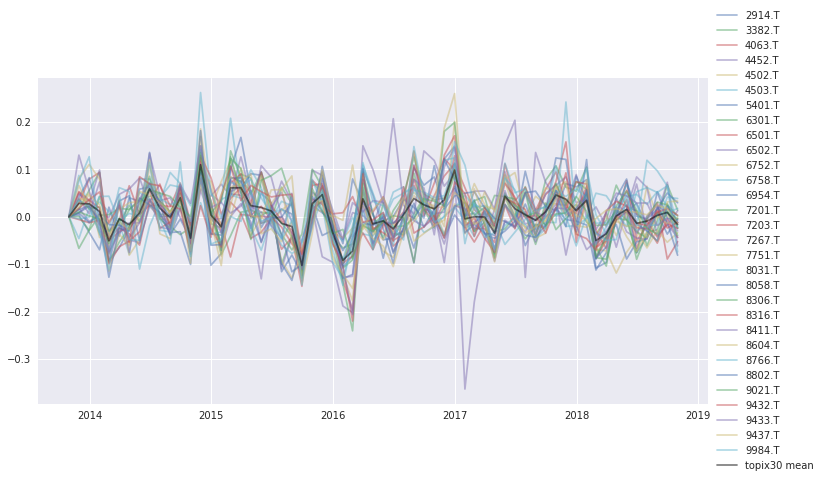

In [40]:
df_retchg = df.pct_change()
df_retchg[:1] = 0.0 # set 0.0 to the first record

plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.plot(df_retchg.index, df_retchg[col], label=col, alpha=0.5)
plt.plot(df_retchg.index, df_retchg.mean(axis='columns'), label="topix30 mean", color="black", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

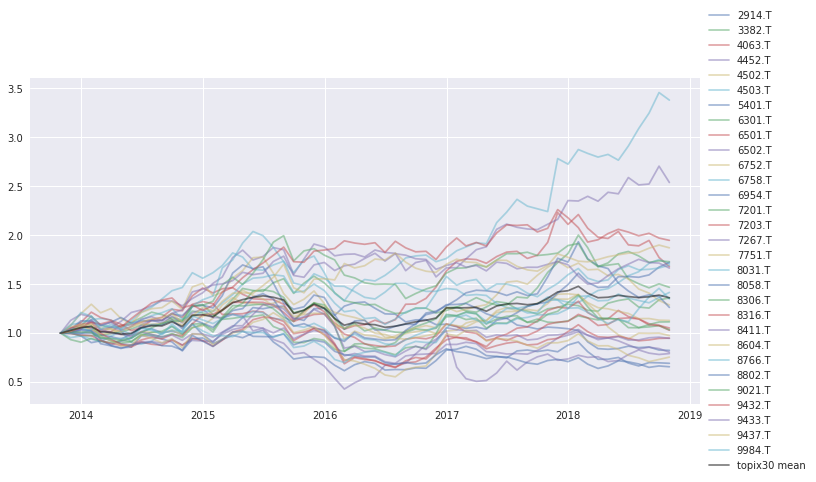

In [41]:
df_retcum = (1.0 + df_retchg).cumprod()
df_retcum[:1] = 1.0 # set 1.0 to the first record

plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.plot(df_retcum.index, df_retcum[col], label=col, alpha=0.5)
plt.plot(df_retcum.index, df_retcum.mean(axis='columns'), label="topix30 mean", color="black", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()